In [1]:
from video_sampler.visualisation.clustering import extract_features
from pathlib import Path
import numpy as np 

folder_str = "../scratch/{}/HighLemurs.mp4"
features = extract_features(
    "microsoft/resnet-50",
    image_folder=Path(folder_str.format("passthrough")),
)
hash_paths = [x.name for x in Path(folder_str.format("hash")).iterdir()]
hash8_paths = [x.name for x in Path(folder_str.format("hash8")).iterdir()]
mask4 =[
    x in hash_paths for x in features["paths"]
]
mask8 =[
    x in hash8_paths for x in features["paths"]
]


/Users/jm/repos/video_sampler/.sampler/lib/python3.11/site-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(
21it [00:12,  1.63it/s]                        


# Similarity distribution

This double counts but it's fine for now.
I'm using KL divergence and the distribution of similarities to determine the sampling distortion.

/var/folders/wq/0q9brtfs5rq65q1t_mtgshb00000gn/T/ipykernel_1277/2374471246.py:8: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))
/var/folders/wq/0q9brtfs5rq65q1t_mtgshb00000gn/T/ipykernel_1277/2374471246.py:8: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))


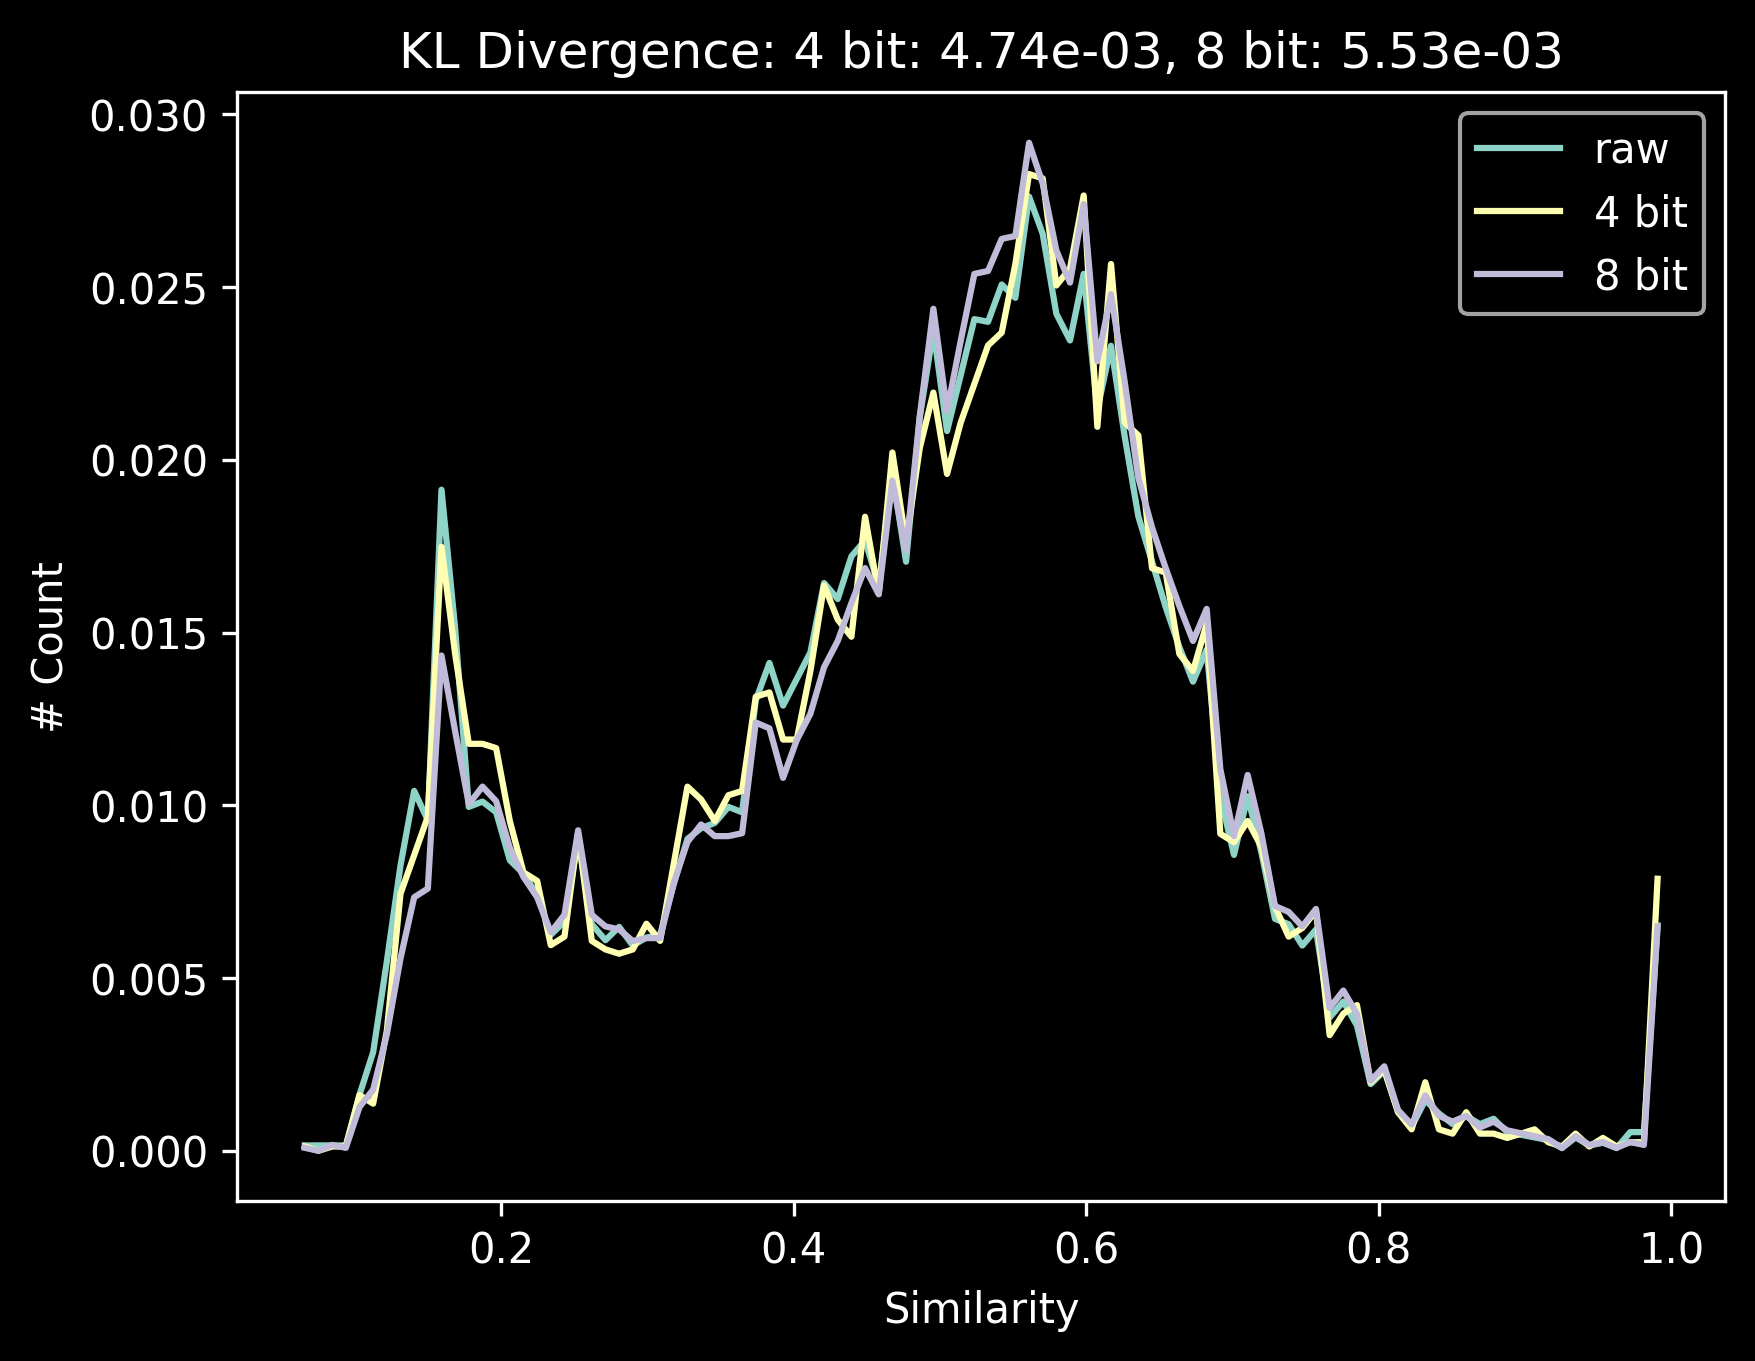

In [3]:
from matplotlib import pyplot as plt   
# normalise
feats = np.asarray(features["embeds"])
feats = feats / np.linalg.norm(feats, axis=1, keepdims=True)
similarity = feats @ feats.T

def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

with plt.style.context(['dark_background']):
    fig, ax = plt.subplots(dpi=300)
    # keep the bins the same 

    hist, edges = np.histogram(similarity.flatten(), bins=100)
    histvals = hist / hist.max() # don't make it a pdf, equalize the height
    histvals = histvals / histvals.sum() # make it a pdf
    ax.plot(edges[:-1], histvals, label="raw")
    hist, edges = np.histogram(similarity[mask4][:, mask4].flatten(), bins=edges)
    histvals4 = hist / hist.max()
    histvals4 = histvals4 / histvals4.sum()
    ax.plot(edges[:-1], histvals4, label="4 bit")
    hist, edges = np.histogram(similarity[mask8][:, mask8].flatten(), bins=edges)
    histvals8 = hist / hist.max()
    histvals8 = histvals8 / histvals8.sum()
    ax.plot(edges[:-1], histvals8, label="8 bit")
    ax.legend()
    ax.set_xlabel("Similarity")
    ax.set_ylabel("# Count")

    kl4 = kl_divergence(histvals4, histvals)
    kl8 = kl_divergence(histvals8, histvals)

    ax.set_title(f"KL Divergence: 4 bit: {kl4:.2e}, 8 bit: {kl8:.2e}")

fig